In [1]:
import numpy as np
import joblib
import os
import pandas as pd

# 使用网格搜索方法来进行参数选择
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

from sklearn.preprocessing import LabelEncoder

from collections import Counter
# 使用StratifiedShuffleSplit类进行分层抽样
from imblearn.over_sampling import SMOTE, ADASYN, BorderlineSMOTE, SVMSMOTE, KMeansSMOTE
from data_process.light_curve import ASASLightCurve

# 使用StratifiedShuffleSplit类进行分层抽样
from sklearn.model_selection import train_test_split


In [2]:
cepheid_list = np.load("../dataset/light_curve_instance/cepheid/lc_cepheid.npy", allow_pickle=True)
len(cepheid_list)

4648

In [3]:
print(cepheid_list[0].meta)

OrderedDict([('source_id', '247819'), ('raj2000', 310.79987), ('dej2000', 67.24633), ('l', 102.21333), ('b', 15.0233), ('mean_vmag', 12.62), ('amplitude', 0.35), ('period', 3.9266335), ('variable_type', 'DCEPS'), ('class_probability', 0.994), ('lksl_statistic', 0.02), ('rfr_score', 0.99), ('epoch_hjd', 2457964.866), ('gdr2_id', 2.24612e+18), ('phot_g_mean_mag', 12.372836), ('e_phot_g_mean_mag', 0.00589), ('phot_bp_mean_mag', 12.886092), ('e_phot_bp_mean_mag', 0.019282), ('phot_rp_mean_mag', 11.697652), ('e_phot_rp_mean_mag', 0.012048), ('bp_rp', 1.18844), ('parallax', 0.0751), ('parallax_error', 0.01), ('parallax_over_error', 7.5443), ('pmra', -0.769), ('pmra_error', 0.012), ('pmdec', -0.959), ('pmdec_error', 0.012), ('vt', 0.521547973), ('dist', 11171.7793), ('j_mag', 10.867), ('e_j_mag', 0.021), ('h_mag', 10.539), ('e_h_mag', 0.028), ('k_mag', 10.461), ('e_k_mag', 0.022), ('w1_mag', 10.329), ('e_w1_mag', 0.023), ('w2_mag', 10.327), ('e_w2_mag', 0.02), ('w3_mag', 10.275), ('e_w3_mag',

In [4]:
from tqdm import tqdm

full_lc_pd = pd.DataFrame(columns=cepheid_list[0].meta.keys())
for lc in tqdm(cepheid_list):
    full_lc_pd = full_lc_pd.append(lc.meta, ignore_index=True)
full_lc_pd

100%|██████████| 4648/4648 [00:24<00:00, 189.59it/s]


,source_id,raj2000,dej2000,l,b,mean_vmag,amplitude,period,variable_type,class_probability,...,pearsonr,Mm_period_ratio,l1,slope_per10,slope_per90,slope_per20,slope_per80,phase_cusum,j_h,h_k
0,247819,310.79987,67.24633,102.21333,15.02330,12.62,0.35,3.926633,DCEPS,0.994,...,0.817310,0.445488,0.958295,-5.687144,8.008793,-1.898098,3.878650,0.436784,0.328,0.078
1,AP36309917,77.32044,-64.70331,274.78448,-35.18470,15.18,0.36,2.088684,DCEPS,0.910,...,-0.803812,0.369049,0.830162,-0.937212,0.662440,-0.394233,0.340217,0.456209,0.385,0.143
2,AP36309917,77.32044,-64.70331,274.78448,-35.18470,15.18,0.36,2.088684,DCEPS,0.910,...,-0.782158,0.201067,0.807894,-0.381057,0.363685,-0.140914,0.178288,0.435883,0.385,0.143
3,465269,294.76155,24.38494,59.88100,1.20807,14.73,0.58,5.171102,DCEP,0.315,...,0.747205,0.652410,0.942369,-2.501995,3.541191,-0.933468,1.772922,0.510828,0.754,0.323
4,522654,218.81848,-67.37944,312.68775,-6.49576,16.03,1.05,2.242517,CWB,0.308,...,0.562861,0.266138,0.792623,-0.268636,0.205061,-0.112563,0.114487,0.292923,0.427,0.196
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,AP36282103,82.31937,-67.47275,277.68457,-32.73992,14.07,0.87,13.420894,DCEP,0.998,...,0.938600,0.454573,0.974491,-3.270565,3.443486,-1.536690,1.231369,0.382776,0.441,0.050
4644,247842,273.47423,-64.60680,329.77829,-20.46853,14.19,1.20,1.730097,DCEP,0.985,...,-0.409689,0.202314,0.940084,-0.363470,0.910712,-0.166356,0.450779,0.483828,0.246,0.055
4645,AP36285593,81.16232,-66.43103,276.52916,-33.33331,14.84,0.50,8.926746,DCEP,0.985,...,-0.471253,0.682410,0.925440,-5.456310,2.382115,-2.305983,1.216406,0.488884,0.336,0.132
4646,AP36285593,81.16232,-66.43103,276.52916,-33.33331,14.84,0.50,8.926746,DCEP,0.985,...,-0.860432,0.711840,0.937132,-1.908869,1.647371,-0.872921,0.851560,0.500447,0.336,0.132


In [5]:
full_lc_pd.to_csv("../dataset/light_curve_dataframe/cepheid/lc_cepheid.csv", index=False)

In [61]:
full_lc_pd = pd.read_csv("../dataset/light_curve_dataframe/cepheid/lc_cepheid.csv")

In [62]:
# delete_idx = full_lc_pd[full_lc_pd["peri_optical"].isnull() == True].index
# full_lc_pd = full_lc_pd.drop(delete_idx)

In [63]:
sub_class = full_lc_pd["variable_type"]
features_drop_unlabel = full_lc_pd.drop(
    labels=["source_id", "class_probability", "variable_type", "created_at", "main_type", "updated_at", "mean_vmag",
            "lksl_statistic", "rfr_score", "epoch_hjd", "e_b_v", "vector_x", "vector_y", "vector_z", "periodic"],
    axis=1)
features_drop_unlabel = features_drop_unlabel.dropna(axis=1)
# kim_feature = ['period', 'skewness', 'kurtosis', 'shapiro_w', 'IQR',
#                        'stetson_k', 'hl_amp_ratio', 'h_1', 'r21', 'r31', 'phi21',
#                        'phi31', 'phase_eta', 'slope_per10', 'slope_per90', 'phase_cusum']
# features_drop_unlabel = features_drop_unlabel[kim_feature]
features_drop_unlabel

,raj2000,dej2000,l,b,amplitude,period,mean,median,std,skewness,...,phase_eta,peri_optical,pearsonr,Mm_period_ratio,l1,slope_per10,slope_per90,slope_per20,slope_per80,phase_cusum
0,310.79987,67.24633,102.21333,15.02330,0.35,3.926633,12.624732,12.6440,0.119334,-0.293535,...,0.034235,3.215154,0.817310,0.445488,0.958295,-5.687144,8.008793,-1.898098,3.878650,0.436784
1,77.32044,-64.70331,274.78448,-35.18470,0.36,2.088684,15.190610,15.1960,0.113792,-0.030457,...,0.348689,7.272814,-0.803812,0.369049,0.830162,-0.937212,0.662440,-0.394233,0.340217,0.456209
2,77.32044,-64.70331,274.78448,-35.18470,0.36,2.088684,15.181465,15.1960,0.112264,-0.094424,...,0.393449,7.268436,-0.782158,0.201067,0.807894,-0.381057,0.363685,-0.140914,0.178288,0.435883
3,294.76155,24.38494,59.88100,1.20807,0.58,5.171102,14.729574,14.7665,0.195464,-0.056890,...,0.099079,2.848440,0.747205,0.652410,0.942369,-2.501995,3.541191,-0.933468,1.772922,0.510828
4,218.81848,-67.37944,312.68775,-6.49576,1.05,2.242517,16.050593,16.0630,0.327898,0.106559,...,0.496881,7.157402,0.562861,0.266138,0.792623,-0.268636,0.205061,-0.112563,0.114487,0.292923
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4643,82.31937,-67.47275,277.68457,-32.73992,0.87,13.420894,14.071352,14.0730,0.251560,-0.314950,...,0.037554,1.048466,0.938600,0.454573,0.974491,-3.270565,3.443486,-1.536690,1.231369,0.382776
4644,273.47423,-64.60680,329.77829,-20.46853,1.20,1.730097,14.195057,14.2030,0.347610,-0.332813,...,0.127093,8.204774,-0.409689,0.202314,0.940084,-0.363470,0.910712,-0.166356,0.450779,0.483828
4645,81.16232,-66.43103,276.52916,-33.33331,0.50,8.926746,14.830084,14.8200,0.158128,0.148821,...,0.154566,1.661309,-0.471253,0.682410,0.925440,-5.456310,2.382115,-2.305983,1.216406,0.488884
4646,81.16232,-66.43103,276.52916,-33.33331,0.50,8.926746,14.840917,14.8200,0.162239,0.208626,...,0.131675,1.662523,-0.860432,0.711840,0.937132,-1.908869,1.647371,-0.872921,0.851560,0.500447


In [64]:
label_encoder = LabelEncoder()
sub_class = label_encoder.fit_transform(sub_class)
sub_class = sub_class.astype(np.int32)

In [65]:
np.random.seed(1)
X_train, X_test, y_train, y_test = train_test_split(features_drop_unlabel, sub_class, test_size=0.2, shuffle=True,
                                                    random_state=0)
X_train, y_train = SVMSMOTE(random_state=1).fit_resample(X_train, y_train)
print(sorted(Counter(y_train).items()))

[(0, 1633), (1, 1633), (2, 1633), (3, 1633), (4, 1633)]


In [66]:
param_grid = [
    {'n_estimators': [100, 200]},
]
other_params = {'n_estimators': 90, 'criterion': 'entropy', 'max_depth': None, 'min_samples_split': 5,
                'min_samples_leaf': 1,
                'min_weight_fraction_leaf': 0.0,
                'max_features': 30, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'bootstrap': True,
                'oob_score': True, 'warm_start': False, 'class_weight': None, 'ccp_alpha': 0.0, 'max_samples': None}
clf = RandomForestClassifier(n_jobs=-1, random_state=0, **other_params)
grid_search = GridSearchCV(clf, param_grid, cv=5, scoring="accuracy", return_train_score=True, verbose=10)

grid_search.fit(X_train, y_train)
print(grid_search.best_params_)
print(grid_search.best_estimator_)
print(grid_search.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV 1/5; 1/2] START n_estimators=100............................................
[CV 1/5; 1/2] END n_estimators=100;, score=(train=1.000, test=0.923) total time=   2.6s
[CV 2/5; 1/2] START n_estimators=100............................................
[CV 2/5; 1/2] END n_estimators=100;, score=(train=1.000, test=0.930) total time=   2.8s
[CV 3/5; 1/2] START n_estimators=100............................................
[CV 3/5; 1/2] END n_estimators=100;, score=(train=1.000, test=0.932) total time=   2.9s
[CV 4/5; 1/2] START n_estimators=100............................................
[CV 4/5; 1/2] END n_estimators=100;, score=(train=1.000, test=0.938) total time=   3.6s
[CV 5/5; 1/2] START n_estimators=100............................................
[CV 5/5; 1/2] END n_estimators=100;, score=(train=1.000, test=0.921) total time=   3.6s
[CV 1/5; 2/2] START n_estimators=200............................................
[CV 1/5; 2/2] 

In [67]:
grid_search.score(X_test, y_test)

0.8903225806451613

In [68]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(mean_score, params)

0.9285976729944887 {'n_estimators': 100}
0.9303123086344153 {'n_estimators': 200}


In [69]:
# 计算每种特征对分类结果的影响
feature_name = features_drop_unlabel.columns
feature_importances = grid_search.best_estimator_.feature_importances_
sorted(zip(feature_importances, feature_name), reverse=True)

[(0.1988257595766246, 'period'),
 (0.13733809242290557, 'peri_optical'),
 (0.10967797035875097, 'r21'),
 (0.06329724229171545, 'b2'),
 (0.05907220606352802, 'slope_per10'),
 (0.05897340395582644, 'b1'),
 (0.02780182339956469, 'b21'),
 (0.02714467877686208, 'raj2000'),
 (0.026358500684495106, 'slope_per20'),
 (0.01745893054711534, 'r31'),
 (0.016658251236166512, 'b'),
 (0.015732905327556522, 'slope_per90'),
 (0.014496360342003365, 'dej2000'),
 (0.013178593723600794, 'l'),
 (0.01291743746798447, 'r41'),
 (0.012003792165351216, 'slope_per80'),
 (0.009099406531093658, 'b3'),
 (0.00772633859276738, 'amplitude'),
 (0.006902638227933404, 'mean'),
 (0.00593240023110519, 'median'),
 (0.0057868589492343645, 'std'),
 (0.004711351397545115, 'phase_eta'),
 (0.00460993895531595, 'phase_cusum'),
 (0.0043911072973522565, 'r32'),
 (0.00433658343346731, 'b4'),
 (0.0043346993218329, 'l1'),
 (0.004095307601650288, 'h_1'),
 (0.003992119368545949, 'skewness'),
 (0.003890910658220867, 'hl_amp_ratio'),
 (0.00

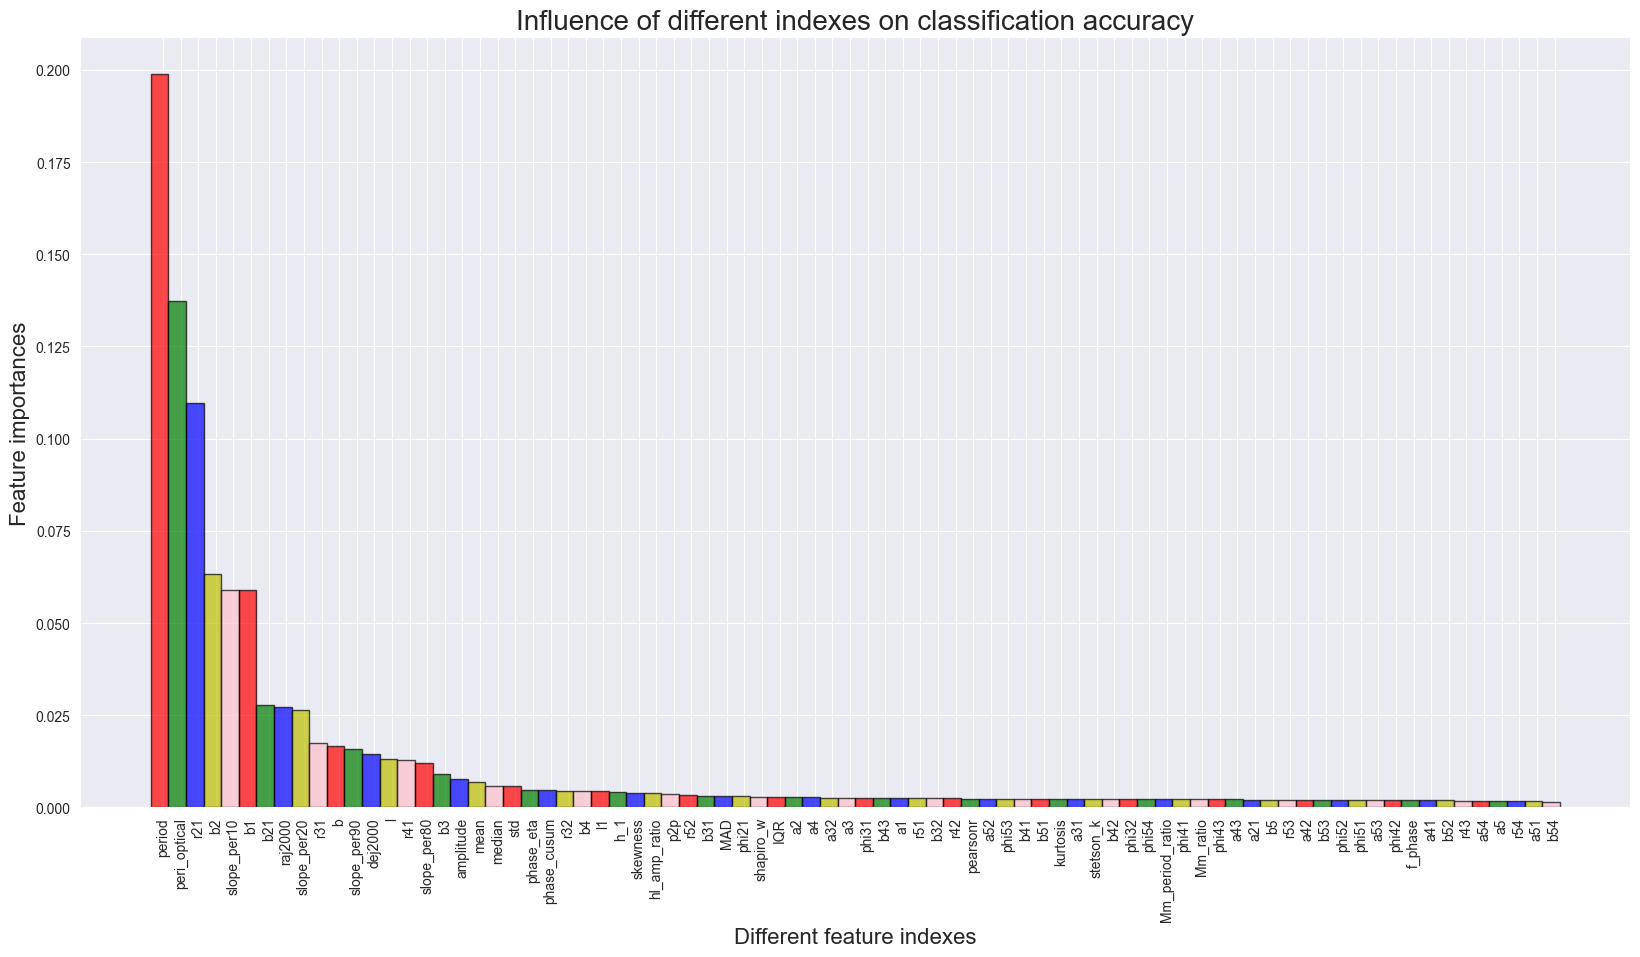

FileNotFoundError: [Errno 2] No such file or directory: './output/feature_important/random_forest_cepheids_importance_0.9303123086344153.png'

<Figure size 640x480 with 0 Axes>

In [70]:
import matplotlib.pyplot as plt

importances = sorted(zip(feature_importances, feature_name), reverse=True)
feature_im = []
feature_n = []
for i in importances:
    feature_im.append(i[0])
    feature_n.append(i[1])
plt.figure(figsize=(20, 10))
indexes = np.arange(len(feature_im))
plt.title("Influence of different indexes on classification accuracy", fontsize=20)
plt.xlabel("Different feature indexes", fontsize=16)
plt.ylabel("Feature importances", fontsize=16)
plt.bar(2 * indexes, feature_im, 2, edgecolor="black", alpha=0.7, color=['r', 'g', 'b', 'y', 'pink'])
plt.xticks(2 * indexes + 2 * 0.2, feature_n, rotation=90)
plt.show()
plt.savefig(f"./output/feature_important/random_forest_cepheids_importance_{grid_search.best_score_}.png")

([<matplotlib.axis.YTick at 0x23ceb9edd80>,
 [Text(0, 0, 'CWA'),
  Text(0, 1, 'CWB'),
  Text(0, 2, 'DCEP'),
  Text(0, 3, 'DCEPS'),
  Text(0, 4, 'RVA')])

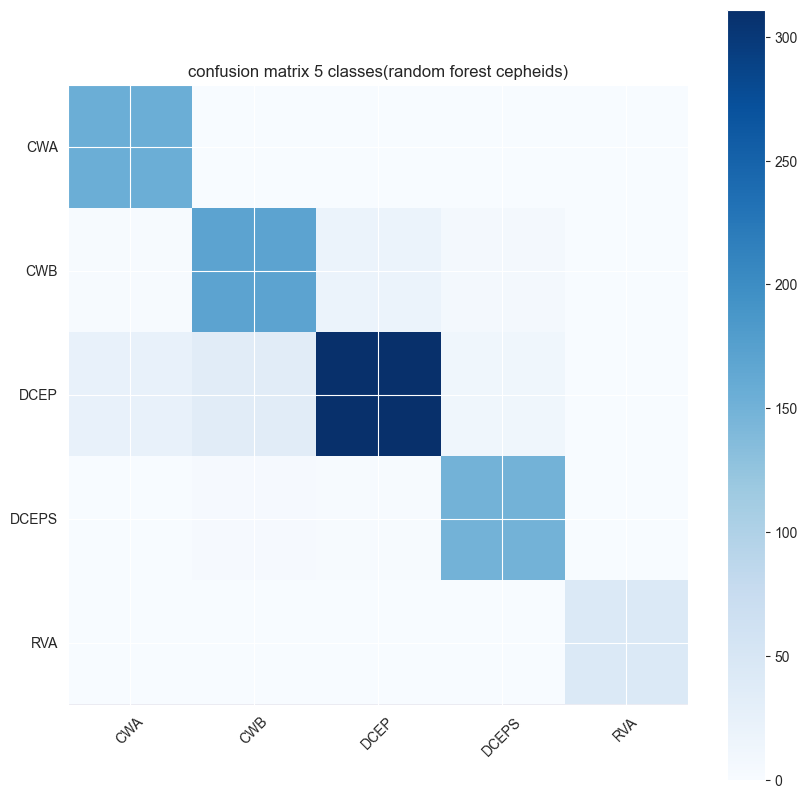

In [71]:
# from my_util.utils import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

y_pred = grid_search.predict(X_test)
cm = confusion_matrix(y_test, y_pred)

classes = np.unique(np.concatenate([np.array(y_test), np.array(y_pred)]))
classes = label_encoder.inverse_transform(classes)
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('confusion matrix 5 classes(random forest cepheids)')
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

In [72]:
from sklearn.metrics import recall_score, precision_score, f1_score, classification_report

print(recall_score(y_test, y_pred, average='macro'))
print(f1_score(y_test, y_pred, average='macro'))
print(precision_score(y_test, y_pred, average='macro'))
print(recall_score(y_test, y_pred, average='macro'))
print(classification_report(y_test, y_pred, target_names=classes, digits=4))

0.9243839151531048
0.9090944278022336
0.8980057760178243
0.9243839151531048
              precision    recall  f1-score   support

         CWA     0.8611    0.9936    0.9226       156
         CWB     0.8173    0.8629    0.8395       197
        DCEP     0.9367    0.8206    0.8748       379
       DCEPS     0.8976    0.9675    0.9312       154
         RVA     0.9773    0.9773    0.9773        44

    accuracy                         0.8903       930
   macro avg     0.8980    0.9244    0.9091       930
weighted avg     0.8942    0.8903    0.8896       930



In [60]:
joblib.dump(label_encoder, f"../output/models/cepheids/rf_cepheids_topall_smSMOTE.pkl")

['../output/models/cepheids/rf_cepheids_topall_smSMOTE.pkl']